In [1]:
!pip install -q kaggle
!pip install transformers
!pip install unidecode
!pip install torch
!pip install tqdm
!pip install transformers


     |████████████████████████████████| 241 kB 12.7 MB/s 


In [2]:
from google.colab import files
from tqdm import tqdm
tqdm.pandas()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gabib3b","key":"817d7e169db4cbef867b22907320144c"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c home-depot-product-search-relevance

  0% 0.00/227k [00:00<?, ?B/s]
100% 227k/227k [00:00<00:00, 86.4MB/s]
  0% 0.00/105k [00:00<?, ?B/s]
100% 105k/105k [00:00<00:00, 103MB/s]
  0% 0.00/2.51M [00:00<?, ?B/s]
100% 2.51M/2.51M [00:00<00:00, 83.1MB/s]
 72% 25.0M/34.8M [00:00<00:00, 37.6MB/s]
100% 34.8M/34.8M [00:00<00:00, 70.7MB/s]
 33% 9.00M/27.2M [00:00<00:00, 28.1MB/s]
100% 27.2M/27.2M [00:00<00:00, 68.7MB/s]
100% 4.74M/4.74M [00:00<00:00, 34.1MB/s]



In [5]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer
import nltk 
import unidecode
import re
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
import seaborn as sns


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
!ls

attributes.csv.zip	      relevance_instructions.docx  test.csv.zip
kaggle.json		      sample_data		   train.csv.zip
product_descriptions.csv.zip  sample_submission.csv.zip


In [7]:
att_df= pd.read_csv('attributes.csv.zip')
desc_df= pd.read_csv('product_descriptions.csv.zip')
train_df= pd.read_csv('train.csv.zip', encoding='latin-1')
test_df = pd.read_csv('test.csv.zip',encoding='latin-1')


In [8]:
desc_df = desc_df.fillna(0)
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)
att_df = att_df.fillna(0)

desc_df['product_uid'] = desc_df['product_uid'].astype(np.int64)
train_df['product_uid'] = train_df['product_uid'].astype(np.int64)
test_df['product_uid'] = test_df['product_uid'].astype(np.int64)
att_df['product_uid'] = att_df['product_uid'].astype(np.int64)

In [9]:
train_df.sample(2)

,id,product_uid,product_title,search_term,relevance
36655,112068,136796,Household Essentials 12 in. Under Sink Sliding...,under cabinet storage,2.00
20417,63007,117115,Home Styles Kitchen Cart in Natural Wood,spacer bar for kitchen cabinets,1.67


In [10]:
np.min(train_df['relevance'].tolist()), np.max(train_df['relevance'].tolist())

(1.0, 3.0)

In [11]:
sorted(pd.unique(train_df['relevance']).tolist())

[1.0, 1.25, 1.33, 1.5, 1.67, 1.75, 2.0, 2.25, 2.33, 2.5, 2.67, 2.75, 3.0]

In [12]:
# train_df['my_relevance'] = train_df['relevance'].apply(lambda x: (x - 1.0)/2.0)

In [13]:
# np.min(train_df['my_relevance'].tolist()), np.max(train_df['my_relevance'].tolist())

(0.0, 1.0)

In [14]:
# train_df['my_relevance2'] = train_df['my_relevance'].apply(lambda x: ((x - 0.0)/1.0) * 2.0 + 1)

In [15]:
# train_df[['relevance', 'my_relevance', 'my_relevance2']].sample(4)

,relevance,my_relevance,my_relevance2
42392,2.00,0.500,2.00
67764,3.00,1.000,3.00
20523,2.67,0.835,2.67
72001,2.00,0.500,2.00


In [ ]:
train_df.describe()

,id,product_uid,relevance,my_relevance,my_relevance2
count,74067.000000,74067.000000,74067.000000,74067.000000,74067.000000
mean,112385.709223,142331.911553,2.381634,0.690817,2.381634
std,64016.573650,30770.774864,0.533984,0.266992,0.533984
min,2.000000,100001.000000,1.000000,0.000000,1.000000
25%,57163.500000,115128.500000,2.000000,0.500000,2.000000
50%,113228.000000,137334.000000,2.330000,0.665000,2.330000
75%,168275.500000,166883.500000,3.000000,1.000000,3.000000
max,221473.000000,206650.000000,3.000000,1.000000,3.000000


In [ ]:
# train_df.drop_duplicates(["product_uid"]).shape[0]/len(train_df)

0.7380749861611784

In [ ]:
# pd.merge(train_df, desc_df, how='left', on='product_uid').shape[0]

74067

In [ ]:
train_df.shape[0]

74067

In [18]:
from transformers import BertTokenizerFast
from transformers import BertTokenizer


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
MAX_SEARCH_TERM_LENGTH = 5
MAX_TITLE_LENGTH = 15

In [17]:
def tokenize(text, max_length):
  
  return tokenizer.encode_plus(
            text,
            max_length = max_length, 
            padding = 'max_length',
            truncation = True, 
            return_attention_mask = False, 
            add_special_tokens = True, 
            )['input_ids']
  


In [ ]:
# tokenize("he went home 123 times, before we --gabi op. -;[]")

['went', 'home', '###', 'time', 'befor', 'gabi', 'op']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


0.9997299742125373

In [19]:
train_df['product_title_tokens'] = train_df['product_title'].progress_apply(lambda text: tokenize(text, MAX_TITLE_LENGTH))

100%|██████████| 74067/74067 [00:36<00:00, 2024.02it/s]


In [20]:
train_df['search_term_tokens'] = train_df['search_term'].progress_apply(lambda text: tokenize(text, MAX_SEARCH_TERM_LENGTH))

100%|██████████| 74067/74067 [00:17<00:00, 4151.82it/s]


In [21]:

test_df['product_title_tokens'] = test_df['product_title'].progress_apply(lambda text: tokenize(text, MAX_TITLE_LENGTH))


100%|██████████| 166693/166693 [01:24<00:00, 1975.42it/s]


In [22]:
test_df['search_term_tokens'] = test_df['search_term'].progress_apply(lambda text: tokenize(text, MAX_SEARCH_TERM_LENGTH))

100%|██████████| 166693/166693 [00:38<00:00, 4276.55it/s]


In [24]:
pd.set_option("max_colwidth", -1)

original_train_df_length = len(train_df)
train_df = train_df[train_df['search_term_tokens'].notnull()]
len(train_df)/original_train_df_length

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


1.0

In [25]:
train_df.sample(3)

,id,product_uid,product_title,search_term,relevance,product_title_tokens,search_term_tokens
7715,24056,104770,Slant/Fin Fine/Line 30 8 ft. Fully Assembled Enclosure and Element Hydronic Baseboard,furnace for baseboard heating,1.00,"[101, 27474, 1013, 10346, 2986, 1013, 2240, 2382, 1022, 3027, 1012, 3929, 9240, 17539, 102]","[101, 17533, 2005, 2918, 102]"
2539,7801,101314,House of Fara 3/4 in. x 3 in. x 7 ft. Oak Door Trim Casing Set,door trim,2.33,"[101, 2160, 1997, 2521, 2050, 1017, 1013, 1018, 1999, 1012, 1060, 1017, 1999, 1012, 102]","[101, 2341, 12241, 102, 0]"
41219,125574,143218,Sumner Street Home Hardware Elon 13/16 in. Satin Nickel Pull,satin nickel pull,3.00,"[101, 23922, 2395, 2188, 8051, 3449, 2239, 2410, 1013, 2385, 1999, 1012, 19412, 15519, 102]","[101, 19412, 15519, 4139, 102]"


In [30]:

relevance_values = pd.unique(train_df['relevance']).tolist()

relevance_map = {relevance: index for (index, relevance) in enumerate(relevance_values)}
num_of_classes = len(relevance_map)
relevance_map, num_of_classes

({1.0: 5,
  1.25: 8,
  1.33: 7,
  1.5: 11,
  1.67: 6,
  1.75: 10,
  2.0: 4,
  2.25: 12,
  2.33: 2,
  2.5: 1,
  2.67: 3,
  2.75: 9,
  3.0: 0},
 13)

In [31]:
cls_to_score = {cls: score for (score, cls) in relevance_map.items()}
cls_to_score


{0: 3.0,
 1: 2.5,
 2: 2.33,
 3: 2.67,
 4: 2.0,
 5: 1.0,
 6: 1.67,
 7: 1.33,
 8: 1.25,
 9: 2.75,
 10: 1.75,
 11: 1.5,
 12: 2.25}

In [32]:

train_df['relevance_class'] = train_df['relevance'].apply(lambda relevance: relevance_map[relevance])
pd.unique(train_df['relevance_class'])


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

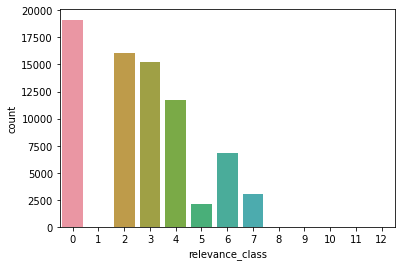

In [33]:
ax = sns.countplot(x="relevance_class", data=train_df)


In [100]:
num_of_classes = len(pd.unique(train_df['relevance_class']))
num_of_classes

13

In [27]:
1

1

In [34]:
test_df['relevance_class'] = -1

In [38]:
train_df.sample(1)

,id,product_uid,product_title,search_term,relevance,product_title_tokens,search_term_tokens,relevance_class
16245,50141,112776,Moto Shade 10 ft. x 20 ft. Multi-Purpose Canopy,car canopy,2.67,"[101, 9587, 3406, 8703, 2184, 3027, 1012, 1060, 2322, 3027, 1012, 4800, 1011, 3800, 102]","[101, 2482, 14582, 102, 0]",3


In [108]:
import random
import time
random.seed(int(time.time()))
from torch.utils.data import Dataset,DataLoader
import torch
from torch import nn, utils
import torch.nn.functional as F
from torch.autograd import Variable 
from torch.optim.lr_scheduler import ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

class DatasetLoader(Dataset):

    def __init__(self, df):
        self._df = df


    def __len__(self):
        return len(self._df)
    def __getitem__(self, idx):
        row = self._df.iloc[idx]

        search_term = np.array(row['search_term_tokens'])
        product_title = np.array(row['product_title_tokens'])

   

        return row['id'], search_term, product_title, row['relevance_class']
    


In [36]:
train_df.sample(1)

,id,product_uid,product_title,search_term,relevance,product_title_tokens,search_term_tokens,relevance_class
37754,115393,138330,Oakland Living Mississippi Patio Service Cart,service cart,3.0,"[101, 9182, 2542, 5900, 19404, 2326, 11122, 102, 0, 0, 0, 0, 0, 0, 0]","[101, 2326, 11122, 102, 0]",0


In [109]:
BATCH_SIZE = 64
train_data_df = train_df[['id', 'product_title_tokens', 'search_term_tokens', 'relevance_class', 'relevance']]
data_loader = DatasetLoader(train_data_df)

train_data_loader = torch.utils.data.DataLoader(data_loader,
                                                 batch_size=BATCH_SIZE, shuffle=True, 
                                                 num_workers=4,drop_last=False)


test_df_fixed = test_df[(test_df['search_term_tokens'].map(len) > 0) & (test_df['product_title_tokens'].map(len) > 0)]



test_loader = DatasetLoader(test_df_fixed[['id', 'product_title_tokens', 'search_term_tokens', 'relevance_class']])

test_data_loader = torch.utils.data.DataLoader(test_loader,
                                                 batch_size=BATCH_SIZE, shuffle=False, 
                                                 num_workers=4,drop_last=False)

len(data_loader), len(test_loader)

(74067, 166693)

In [42]:
train_data_df.sample(1)

,id,product_title_tokens,search_term_tokens,relevance_class,relevance
39466,120409,"[101, 20868, 12173, 2937, 2102, 4293, 3027, 1012, 4658, 2317, 2419, 8164, 2422, 8934, 102]","[101, 4029, 3027, 2419, 102]",2,2.33


,id,product_uid,product_title,search_term,product_title_tokens,search_term_tokens,my_relevance
35646,52729,113622,AT&amp;T Trimline Telephone With Memory - Black,at,"[amp, <word>, telephon, memori, black]",[],1


In [110]:
for ids, search_term, product_title, target_relevance_score in test_data_loader:
  break

In [74]:
for ids, search_term, product_title, target_relevance_score in train_data_loader:
  break



In [112]:
# from transformers import BertConfig

# config = BertConfig.from_pretrained("bert-base-uncased",
#                                     output_hidden_states=True)

# bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
#                                          config=config)


In [93]:
# bb = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_of_labels = 10)
# tt = torch.from_numpy(np.array(tokenize("he weny home for dinner", 10)))

# dd = tokenizer.encode_plus(
#             text,
#             max_length = max_length, 
#             padding = 'max_length',
#             truncation = True, 
#             return_attention_mask = True, 
#             add_special_tokens = True, 
#             )

# x1 = torch.from_numpy(np.ndarray([]]))
# x2 = torch.from_numpy(np.array([dd['attention_mask']]))


# torch.tensor(product_title)
i1 = torch.tensor([[7,8,9],[10,11,12]])
bert_model(i1)['hidden_states'][-1][:, -1,:].shape

torch.Size([2, 768])

In [136]:
from transformers import BertForSequenceClassification

class RelevanceModel(nn.Module):

  def __init__(self, num_of_classes):
    super(RelevanceModel, self).__init__()
    config = BertConfig.from_pretrained("bert-base-uncased",
                                    output_hidden_states=True)

    self.bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", config=config)

    for param in self.bert_model.parameters():
      param.requires_grad = False

    self.fc = nn.Linear(768 * 2, num_of_classes)

  def  forward(self, queries, titles):
    encoded_queries = self.bert_model(queries)['hidden_states'][-1][:, 0,:]
    #last_hidden_state_cls = outputs[0][:, 0, :]
    encoded_titles = self.bert_model(titles)['hidden_states'][-1][:, 0,:]

    out = torch.cat((encoded_queries, encoded_titles), 1)

    out = self.fc(out)
    
    return out 


  def reset_parameters(self):
    nn.init.uniform_(self.fc.weight)

In [ ]:

# # for x in model.parameters():
# #   if not x.is_cuda:
# #     print(x) 

# # e1 = EncoderModel(len(vocab)).to(device)
# # r = e1(product_title.to(device), product_title_length)
# output.shape, product_title_length
# #output = r 

# #8
# #out_forward = output[range(len(output)), lengths - 1, :self.embedding_dim ]

# # output[range(len(output)), product_title_length - 1, :300][0]
# product_title_length
#output[0][14], product_title_length

tensor([14, 12, 10, 15,  8])

In [ ]:
# output[0][13][300:]
# output[:, 0, 300 :].shape, output[:, 0,]


(torch.Size([5, 300]), torch.Size([5, 15, 600]))

In [96]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
# query_encoder = EncoderModel(len(vocab))
# title_encoder = EncoderModel(len(vocab))

# query_encoder.reset_parameters()
# title_encoder.reset_parameters()

# #search_term, search_term_length, product_title, product_title_length
# query_encoded = query_encoder(search_term, search_term_length)
# title_encoded = query_encoder(product_title, product_title_length)
# torch.cat((query_encoded, title_encoded), 1)

In [104]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [97]:
counts = train_df.groupby("relevance_class").size().reset_index()
#total = np.sum(counts[0].tolist())

# [(row['relevance_class'],  row[0]/total) for (_, row) in counts[['relevance_class', 0]].iterrows()]

total = 0.0
for _, row in counts[['relevance_class', 0]].iterrows():
  total += row[0]
total 
weights = []
print(total)
for _, row in counts[['relevance_class', 0]].iterrows():
  #print(row[0])
  cls = row['relevance_class']
  # print((cls, row[0]))
  sampeples_weight = (row[0] / total)
  required_weight = 1.0/len(counts)

  # print('-----')
  # print(sampeples_weight)
  # print(required_weight)
  x = required_weight/sampeples_weight
  # print(x)

  weight_for_class_a = (1 / row[0]) * total/len(counts)
  

   
  # weight = x * sampeples_weight
  # print(weight)
  # print('-------')

  weights.append((cls, x))



weights = sorted(weights, key = lambda x: x[0])
weights = [w[1] for w in weights]
weights



74067.0


[0.2979064856711916,
 299.8663967611337,
 0.35476099243222536,
 0.37478368230900794,
 0.4857170962030298,
 2.7066325598392105,
 0.8403335602450647,
 1.8953631199140182,
 1424.3653846153848,
 517.951048951049,
 633.0512820512821,
 1139.4923076923078,
 517.951048951049]

In [98]:
weights

[0.2979064856711916,
 299.8663967611337,
 0.35476099243222536,
 0.37478368230900794,
 0.4857170962030298,
 2.7066325598392105,
 0.8403335602450647,
 1.8953631199140182,
 1424.3653846153848,
 517.951048951049,
 633.0512820512821,
 1139.4923076923078,
 517.951048951049]

In [137]:
model = RelevanceModel(num_of_classes)
model.reset_parameters()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

class_weights=torch.tensor(weights,dtype=torch.float)
criterion = torch.nn.CrossEntropyLoss(weight = class_weights, reduction='sum').to(device)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
class_weights[2].numpy(), weights[2]

(array(0.35470936, dtype=float32), 0.3547093708384031)

In [ ]:

model.train()

for epoc in range(1000):

  running_loss = 0.0
  counter = 0.0

  for ids, search_term, product_title, target_relevance_score  in train_data_loader:
    search_term = Variable(search_term).to(device)
    product_title = Variable(product_title).to(device)
    target_relevance_score = Variable(target_relevance_score).long().to(device)

    optimizer.zero_grad()

    scores = model(search_term, product_title)
    loss = criterion(scores, target_relevance_score)

    

    loss.backward()
    optimizer.step()

    #nn.utils.clip_grad_norm(model.parameters(), 0.5)
    
    running_loss += loss.item()
    counter += search_term.shape[0]
  #   break
  
  # break
  
  print('epoc {} loss {} counter {}'.format(epoc, running_loss/counter, counter))




epoc 0 loss 5.904211499163197 counter 74067.0
epoc 1 loss 4.721187067969865 counter 74067.0
epoc 2 loss 4.33463868285345 counter 74067.0
epoc 3 loss 3.456758809993866 counter 74067.0
epoc 4 loss 3.2386129801780044 counter 74067.0
epoc 5 loss 3.0206837696153364 counter 74067.0
epoc 6 loss 2.9152826146479325 counter 74067.0
epoc 7 loss 2.78654564420181 counter 74067.0
epoc 8 loss 2.383195352694024 counter 74067.0
epoc 9 loss 2.420729046698926 counter 74067.0
epoc 10 loss 2.1488469628688867 counter 74067.0


In [122]:
# mse_loss(scores.view(1, -1), target_relevance_score.view(1, -1))
# counter
torch.argmax(scores, dim=1), target_relevance_score

(tensor([ 0,  0,  4,  4,  6,  0,  0,  6,  4,  0,  7,  1,  4,  4,  7,  5,  6,  6,
          1,  4,  6,  0,  6,  4,  4, 10,  4,  4,  6, 10,  6,  6,  0,  0,  0,  4,
          4,  0,  6,  0,  6, 10,  0,  1, 10,  0,  4,  7,  0,  5,  0,  5,  4, 10,
         10,  4,  4,  0,  7,  7,  6,  4,  6,  0], device='cuda:0'),
 tensor([2, 0, 2, 0, 0, 6, 0, 6, 2, 6, 0, 4, 7, 2, 4, 2, 2, 6, 4, 4, 5, 6, 4, 3,
         6, 0, 0, 2, 0, 0, 6, 3, 2, 4, 3, 0, 0, 4, 0, 0, 4, 4, 4, 0, 0, 0, 2, 4,
         0, 3, 4, 5, 3, 3, 0, 3, 4, 0, 3, 3, 0, 0, 0, 0]))

In [126]:
np.sum(torch.argmax(scores, dim=1).detach().cpu().numpy() == target_relevance_score.numpy())

13

In [ ]:
r1, scores.shape

(52, torch.Size([64, 13]))

In [121]:


model.eval()
test_scores = []
test_ids =[]
tt = []

with torch.no_grad():
  for ids, search_term, product_title, target_relevance_score in train_data_loader:
    search_term = Variable(search_term).to(device)
    product_title = Variable(product_title).to(device)
    

    scores = model(search_term, product_title)

    test_scores.extend(scores.detach().cpu().numpy().flatten().tolist())
    test_ids.extend(ids.numpy().tolist())
    tt.extend(target_relevance_score.numpy().tolist())

    break
  



In [ ]:
for _ in test_data_loader:
  break

In [120]:
model.eval()
test_scores = []
test_ids =[]
tt = []
test_data = []
with torch.no_grad():
  for ids, search_term, product_title, target_relevance_score in test_data_loader:
     
    search_term = Variable(search_term).to(device)
    product_title = Variable(product_title).to(device)
    

    scores = model(search_term, product_title)

    vals = torch.argmax(scores, dim=1).flatten().detach().cpu().numpy().tolist()
    ids = ids.numpy().tolist()

    test_data.extend(zip(ids, vals))



    
  

KeyboardInterrupt: ignored

In [ ]:
# 166693, len(test_data), len(test_df)
all_ids = {x for (x, _) in test_data}

for _, row in test_df.iterrows():
  if row['id'] not in all_ids:
    test_data.append((row['id'], 1))
    
len(test_data)

166693

In [ ]:
pd.DataFrame([(id, cls_to_score[cls]) for (id, cls) in test_data], columns = ["id", "relevance"]).to_csv("test_res.csv", index=  False)

In [ ]:
from google.colab import files
files.download('test_res.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
test_df.sample(1)

,id,product_uid,product_title,search_term,product_title_tokens,search_term_tokens,my_relevance
107023,159578,161578,Speedi-Products 7 in. 24-Gauge Single Wall Stove Pipe 90 Degree Adjustable Elbow in Black Matte,singel wall stove pipe,"[speedi, product, #, ##, gaug, singl, wall, stove, pipe, ##, degre, adjust, elbow, black, matt]","[singel, wall, stove, pipe]",1
